First, we need to import the necessary libraries, and define some functions.

In [1]:
import os
import sys
import h5py
import csv
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [2]:
def plot_confusion_matrix(cm, names, directory, title, cmap=plt.cm.Blues):
    # Plot a confusion matrix.
    # cm is the confusion matrix, names are the names of the classes.
    plt.figure(title)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    for i in range(2):
        for j in range(2):
            plt.text(i,j,cm[j][i],fontsize=24)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label',weight='bold')
    plt.xlabel('Predicted label',weight='bold',labelpad=-1)
    file=directory+'/'+title+'.png'
    plt.savefig(file)
   

def plot_aucroc(tprs,aucs,mean_fpr,saving_path):
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="best")
    roc_file=saving_path+'/roc.png'
    plt.savefig(roc_file)
    
    return mean_auc, std_auc


def scale_norm(data_3D):
    #Feature scaling and mean normalization
    norm_data = data_3D
    for i in range(len(data_3D)):
        for j in range(len(data_3D[0])):
            try:
                norm_data[i][j] = (data_3D[i][j]-data_3D[i][j].min())/(data_3D[i][j].max()-data_3D[i][j].min())
            except:
                continue
    return norm_data

This script had to be executed for a number of times, reducing the time-lenght of the sensors' readings for each iteration. This was implemented using a bash script, and the next command is useful for that.

In [4]:
data_lenght=int(sys.argv[1]) #Initially 300 #amount of data in the array.

print('\nk-NN with {} seconds of data'.format(data_lenght))


k-NN with 300 seconds of data


Now, we need to upload the data and labels. The first data augmentation process is already included in the dataset uploaded to IEEE Dataport, so here we only need to perform the second technique (vector rotations).

In [9]:
main_path="/your/project/folder"
saving_path=os.path.join(main_path,'results','KNN',str(data_lenght))
string_dir='mkdir -p '+saving_path
os.system(string_dir)

#Load data and labels
file_name_h5 = os.path.join(main_path, 'data', "sensors_data_augmented.h5")
h5f = h5py.File(file_name_h5,'r')
sensors_data = h5f['dataset_1'][:]
h5f.close()

labels_data = []
file_name_txt = os.path.join(main_path, 'data', "binary_labels_augmented.txt")
file = open(file_name_txt,"r") 
for line in file:
    labels_data.append(line.strip())
    
print('X:', sensors_data.shape)
print('y:', len(labels_data))

X: (420, 7, 300)
y: 420


In [10]:
#Data augmentation (rotate sensors)
sen_data=sensors_data[:,[1,2,3,4,5,6],:data_lenght]#Not using temperature 
labels=labels_data
indexes=[1,2,3,4,5,6,1,2,3,4,5,6]
for index in range(1,6):
    sen_data=np.concatenate((sen_data,sensors_data[
            :,[indexes[index],indexes[index+1],indexes[index+2],indexes[index+3],
          indexes[index+4],indexes[index+5]],:data_lenght]))
    labels=labels+labels_data
    
print('X_augmented:', sen_data.shape)
print('y_augmented:', len(labels))

X_augmented: (2520, 6, 300)
y_augmented: 2520


We have encoded (one-hot) our labels, and we have to flatten our data to be able to train the kNN classifier.

In [11]:
#Encoding labels
le = preprocessing.LabelEncoder()
labels_data_num = le.fit_transform(labels)
encoding = le.classes_

#Normalization before split and data restrictions
sensors_data_norm=scale_norm(sen_data)

#Flattening data
nsamples, nx, ny = sensors_data_norm.shape
sensors_data_2d = sensors_data_norm.reshape((nsamples,nx*ny))

print('X_flattened:', sensors_data_2d.shape)

X_flattened: (2520, 1800)


Then we created the kNN model, and defined some conditions to perform a grid-search for the best hyperparameters (in this case number of neighbours).

In [12]:
# Create model
model = KNeighborsClassifier(n_neighbors=5)
print("\nModel created successfully!\n")
####hyperparameters
n_neighbors = [5,7,9]

####Complete test
param_grid = dict(n_neighbors=n_neighbors)

#Grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc',
                    cv=2,iid=False)


Model created successfully!



We finally train the model (grid-search included).

Grid search results:

Best: 0.607608 using {'n_neighbors': 7}

mean_test_score (std_test_score): params
0.605577 (0.014141) with: {'n_neighbors': 5}
0.607608 (0.011842) with: {'n_neighbors': 7}
0.606864 (0.009758) with: {'n_neighbors': 9}
Grid search results:

Best: 0.574439 using {'n_neighbors': 5}

mean_test_score (std_test_score): params
0.574439 (0.002110) with: {'n_neighbors': 5}
0.567264 (0.007144) with: {'n_neighbors': 7}
0.563645 (0.004171) with: {'n_neighbors': 9}
Grid search results:

Best: 0.611782 using {'n_neighbors': 5}

mean_test_score (std_test_score): params
0.611782 (0.010444) with: {'n_neighbors': 5}
0.609964 (0.009732) with: {'n_neighbors': 7}
0.607563 (0.010623) with: {'n_neighbors': 9}
Grid search results:

Best: 0.597142 using {'n_neighbors': 7}

mean_test_score (std_test_score): params
0.593281 (0.015894) with: {'n_neighbors': 5}
0.597142 (0.003641) with: {'n_neighbors': 7}
0.592413 (0.006164) with: {'n_neighbors': 9}
Grid search results:

Best: 0.609622 using {

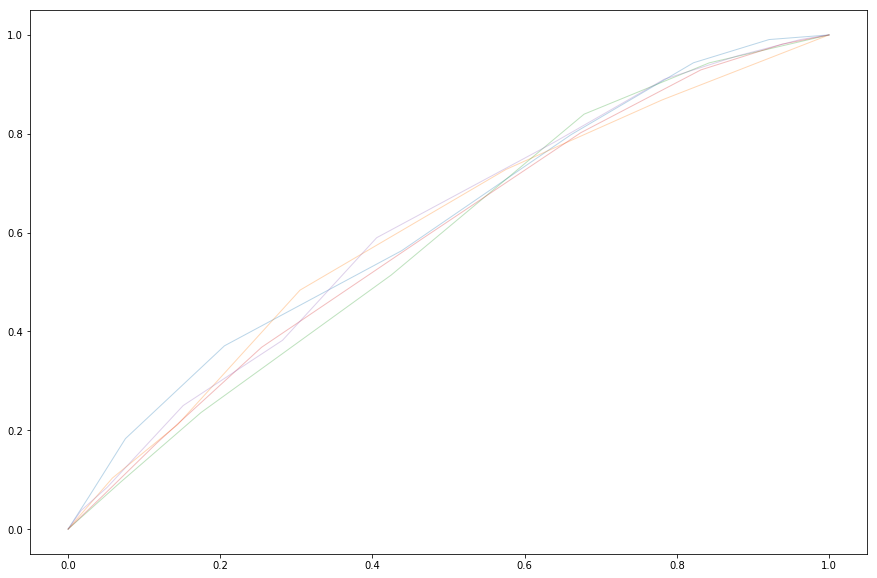

In [13]:
#Training the model
cv= StratifiedKFold(n_splits=5,random_state=1)

tprs = []
aucs = []
pred = []
y=[]
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(sensors_data_2d, labels_data_num):
    grid_result = grid.fit(sensors_data_2d[train],
                        labels_data_num[train])
    # summarize results
    print('Grid search results:\n')
    print("Best: %f using %s" % (grid_result.best_score_,
                                 grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    print('\nmean_test_score (std_test_score): params')
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
        
    clf=grid_result.best_estimator_
    preds = clf.fit(sensors_data_2d[train],
                        labels_data_num[train]).predict_proba(
                                sensors_data_2d[test])
    pred=pred+(np.argmax(preds,axis=1).tolist())
    y=y+(labels_data_num[test].tolist())
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(labels_data_num[test], preds[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.figure('ROC curve',figsize=(15,10))
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
print("\nTraining finished correctly!\n")

With the trained model, and after saving it, we plot the ROC curve. In this case it shows us that our model is at least better than a random classifier.


Model saved!



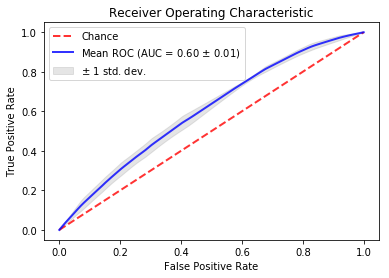

In [14]:
# save the model to disk
file_model=saving_path+'/rf_model.sav'
pickle.dump(model, open(file_model, 'wb'))
print("\nModel saved!\n")

#Print AUC-ROC Curve
mean_auc, std_auc=plot_aucroc(tprs,aucs,mean_fpr,saving_path)

The confusion matrices and the final accuracy let us know how well our classifier performs. We use the accuracy to compare the different models.

Confusion matrix, without normalization
[[863 595]
 [480 582]]
Normalized confusion matrix
[[0.59 0.41]
 [0.45 0.55]]


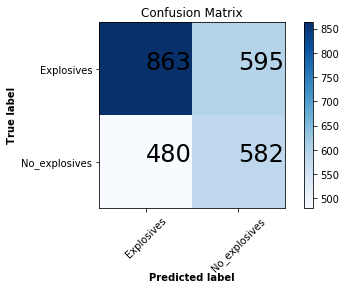

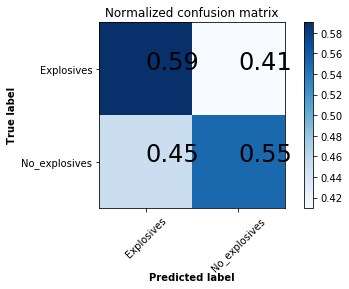

In [15]:
#Confusion matrix
cm = confusion_matrix(labels_data_num, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plot_confusion_matrix(cm, encoding, saving_path, title='Confusion Matrix')
# Normalize the confusion matrix by row
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_norm_round=np.around(cm_normalized,decimals=2)
print('Normalized confusion matrix')
print(cm_norm_round)
plot_confusion_matrix(cm_norm_round, encoding, saving_path, 
                      title='Normalized confusion matrix')

In [16]:
#Calculate classification accuracy
acc=(cm[0][0]+cm[1][1])/len(labels_data_num)
print("Accuracy: {0:.2f}%".format(acc*100))

Accuracy: 57.34%


In [17]:
#Writing to CSV
file_summary=saving_path+'/results_summary.csv'

with open(file_summary, 'w', newline='') as csvfile:
    results = csv.writer(csvfile, delimiter=',')
    results.writerow(['Length of the vectors'])
    results.writerow([data_lenght])
    results.writerow(['Best score'])
    results.writerow([grid_result.best_score_])
    results.writerow(['Parameters'])
    results.writerow([grid_result.best_params_])
    results.writerow(['Accuracy'])
    results.writerow([acc*100])
    results.writerow(['Mean AUC'])
    results.writerow([mean_auc])
    results.writerow(['Std AUC'])
    results.writerow([std_auc])
    results.writerow(['Confusion matrix'])
    results.writerow([cm])
    results.writerow(['Normalized confusion matrix'])
    results.writerow([cm_normalized])

print("\nResults generated correctly!\n")
print("\nJob finished! =) \n")


Results generated correctly!


Job finished! =) 

